# xy''+(1-x)y'+4y=0 with IC as at x=0 y=1 and y'=-4

In [294]:

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import time


class FCN(nn.Module): #Forward Connected Network
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.ReLU()
        
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation])
        self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
    


In [334]:
# This block is for hyperparameters
N_INPUT = 1
N_OUTPUT = 1
N_HIDDEN = 50
N_LAYERS = 7
N_EPOCHS = 7000
LEARNING_RATE = 1e-5
# weight_pde = (np.random.rand(1))[0]
# weight_ic_1 = (np.random.rand(1))[0]
# weight_ic_2 = (np.random.rand(1))[0]
weight_bc = 1.0
T = .1 # Temperature


weight_pde = 1
weight_ic_1 = 1
weight_ic_2 = 1

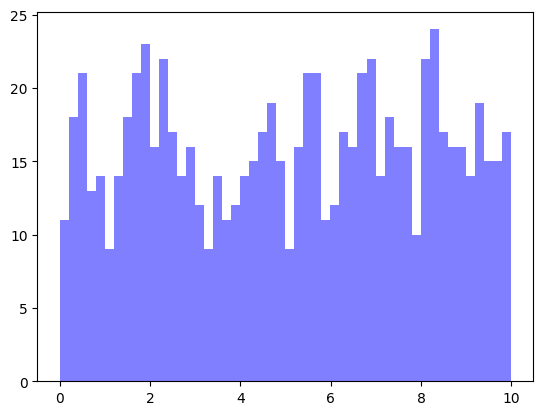

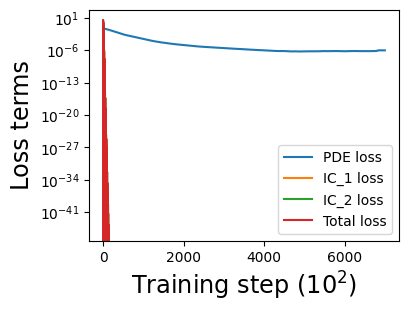

In [343]:
# Importance of requires_grad_(True)
# PyTorch needs to track gradients for the input tensor x_ic when computing derivatives 
# using torch.autograd.grad() so specifying to pytorch x_ic or x_c is used for derivatives
# This must be like tf.watch(x_ic) in tensorflow where the variables whose gradients are taken for
# backpropagation needs to be mentioned to the network

# Collocation points are needed to train network on Physics constraints
xPoints = np.random.rand(800)*10
xPointstocheck = np.array([0,0.935822,3.30541,7.75877])
xPointstocheck = torch.Tensor(xPointstocheck).view(-1,1).requires_grad_(True)
x_c = torch.Tensor(xPoints).view(-1,1).requires_grad_(True)
plt.hist(xPoints, bins=50, color="blue", alpha=0.5)
# Initial Conditions
x_ic = torch.Tensor([0]).view(-1,1).requires_grad_(True) #x = 0 for below two conditions
y_true_ic = torch.Tensor([1]).view(-1,1) #y(0) =1
dy_dx_true_ic = torch.Tensor([-4]).view(-1,1) #dy(0)/dx = -3

# Any other boundary conditions you want to implement
# Supply them through format mentioned above
# B_c = [[...,...],...]
# x_bc = torch.Tensor(B_c[:,0]).view(-1,1)
# y_bc = torch.Tensor(B_c[:,1]).view(-1,1)

torch.manual_seed(int(time.time()))

model = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)
optimizer = torch.optim.Adam(model.parameters(),lr = LEARNING_RATE)
# lr is learning rate

files = []
loss_history = {"pde_loss":[],"ic_1_loss":[],"ic_2_loss":[],"bc_loss":[],"total_loss":[]}
weight_history = {"pde_weight":[],"ic_1_weight":[],"ic_2_weight":[],"bc_weight":[]}
dataframe={"deltapde":[],"deltaic1":[],"deltaic2":[],"w_pde":[],"w_ic1":[],"w_ic2":[],"function":[]}

# Weights for the loss terms when calculating total loss
w_pde = weight_pde
w_ic_1 = weight_ic_1
w_ic_2 = weight_ic_2
W_bc = weight_bc

#Coefficient of y(x) in O.D.E.
lam = 1 

for i in range(N_EPOCHS):
    
    optimizer.zero_grad()

    # if(i>2):
    #     w_pde_tm1 = loss_history["pde_loss"][-1]
    #     w_pde_tm2 = loss_history["pde_loss"][-2]
    #     w_ic1_tm1 = loss_history["ic_1_loss"][-1]
    #     w_ic1_tm2 = loss_history["ic_1_loss"][-2]
    #     w_ic2_tm1 = loss_history["ic_2_loss"][-1]
    #     w_ic2_tm2 = loss_history["ic_2_loss"][-2]

    #     deltapde = (w_pde_tm1 - w_pde_tm2)
    #     deltaic1 = (w_ic1_tm1 - w_ic1_tm2)
    #     deltaic2 = (w_ic2_tm1 - w_ic2_tm2)

    #     denom = np.exp(T*(deltapde)) + np.exp(T*deltaic1) + np.exp(T*deltaic2)
    #     w_pde = np.exp(T*deltapde)/denom
    #     w_ic_1 = np.exp(T*deltaic1)/denom
    #     w_ic_2 = np.exp(T*deltaic2)/denom
    #     # dataframe["w_pde_tm1"].append(w_pde_tm1)
    #     # dataframe["w_pde_tm2"].append(w_pde_tm2)
    #     # dataframe["w_ic1_tm1"].append(w_ic1_tm1)
    #     # dataframe["w_ic1_tm2"].append(w_ic1_tm2)
    #     # dataframe["w_ic2_tm1"].append(w_ic2_tm1)
    #     # dataframe["w_ic2_tm2"].append(w_ic2_tm2)
    #     dataframe["deltapde"].append(deltapde)
    #     dataframe["deltaic1"].append(deltaic1)
    #     dataframe["deltaic2"].append(deltaic2)
    dataframe["w_pde"].append(w_pde)
    dataframe["w_ic1"].append(w_ic_1)
    dataframe["w_ic2"].append(w_ic_2)
    

    w_pde=dataframe["w_pde"][-1]*(-1 + np.random.rand(1)[0]*2)
    w_ic_1=dataframe["w_ic1"][-1]*(-1 + np.random.rand(1)[0]*2) 
    w_ic_2=dataframe["w_ic2"][-1]*(-1 + np.random.rand(1)[0]*2)


    # Computing Physics loss through P.D.E. on collocation points
    y_pred_c = model(x_c)
    dy_dx = torch.autograd.grad(y_pred_c, x_c, grad_outputs=torch.ones_like(y_pred_c), create_graph = True)[0]
    d2y_dx2 = torch.autograd.grad(dy_dx, x_c, grad_outputs=torch.ones_like(dy_dx), create_graph = True)[0]
    
    pde = (x_c*d2y_dx2 + (1-x_c)*dy_dx + 4*y_pred_c) # xy" + (1-x)y' + 4y = 0
    pde_loss = torch.mean(pde**2)
    
    # Same flow for boundary conditions as below
    
    # Computing Physics loss through Initial Conditions
    # y(0) = 1
    y_pred_ic = model(x_ic)
    
    # y'(0) = 1 (using same x_ic and y_pred_ic as we want derivative at same point to give 1)
    # Remember you get a tuple on auto-differentiation so take value at index 0
    dy_dx_pred_ic = torch.autograd.grad(y_pred_ic, x_ic, grad_outputs=torch.ones_like(y_pred_ic), create_graph= True)[0]
    
    #Summing losses of all ICs (can do them seperately too with individual weights if this method isn't reducing IC_loss satifactorily)
    IC_1_loss = w_ic_1*torch.mean((y_pred_ic - y_true_ic)**2)
    IC_2_loss = w_ic_2*torch.mean((dy_dx_pred_ic - dy_dx_true_ic)**2)
    IC_loss = IC_1_loss + IC_2_loss
    
    # Adding the total loss here
    total_loss = w_pde*pde_loss + IC_loss #+ w_bs*BC_loss
    
    (pde_loss).backward()
    IC_loss.backward()
    optimizer.step()

    y_check=model(xPointstocheck)

    # dataframe["deltapde"].append(deltapde.detach().numpy())
    # dataframe["deltaic1"].append(deltaic1.detach().numpy())
    # dataframe["deltaic2"].append(deltaic2.detach().numpy())
    # dataframe["w_pde"].append(w_pde.detach().numpy())
    # dataframe["w_ic1"].append(w_ic_1.detach().numpy())
    # dataframe["w_ic2"].append(w_ic_2.detach().numpy())
    #dataframe["function"].append(y_check.detach().numpy())
    


    loss_history["pde_loss"].append(pde_loss.detach())
    loss_history["ic_1_loss"].append(IC_1_loss.detach())
    loss_history["ic_2_loss"].append(IC_2_loss.detach())
    # loss_history["bc_loss"].append(BC_loss.detach())
    loss_history["total_loss"].append(total_loss.detach())

    weight_history["pde_weight"].append(w_pde)
    weight_history["ic_1_weight"].append(w_ic_1)
    weight_history["ic_2_weight"].append(w_ic_2)
    
    
        # xCheck = np.random.rand(750)*8
        # x_check = torch.Tensor(xCheck).view(-1,1)
        
        # y_pred = model(x_check)
        
        # x_axis = x_check.detach().numpy()
        # y_axis = y_pred.detach().numpy()
            
        # plt.scatter(x_axis,y_axis)
                
        # if (i+1) % 10 == 0: plt.show()
        # else: plt.close("all")

fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(loss_history["pde_loss"], label="PDE loss")

ax.plot(loss_history["ic_1_loss"], label="IC_1 loss")
ax.plot(loss_history["ic_2_loss"], label="IC_2 loss")

#ax.plot(loss_history["bc_loss"], label="BC loss")

ax.plot(loss_history["total_loss"], label="Total loss")
ax.set_yscale('log')

ax.set_xlabel('Training step ($10^2$)',fontsize="xx-large")
ax.set_ylabel('Loss terms',fontsize="xx-large")
ax.legend()

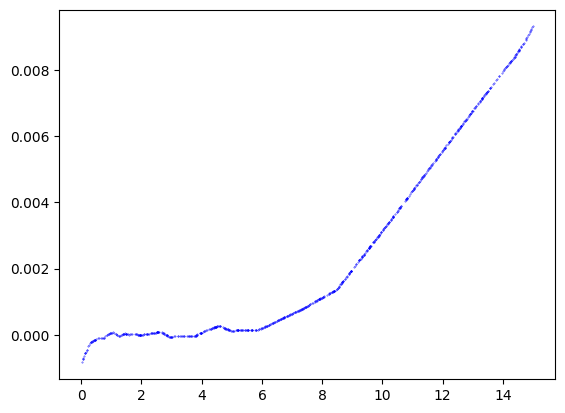

In [344]:
xCheck = np.random.rand(750)*15
x_check = torch.Tensor(xCheck).view(-1,1)
y_pred = model(x_check)
x_axis = x_check.detach().numpy()
y_axis = y_pred.detach().numpy()
plt.scatter(x_axis,y_axis, color="blue", alpha=0.8, label="PINN prediction",marker='.',s=.5)
plt.show()

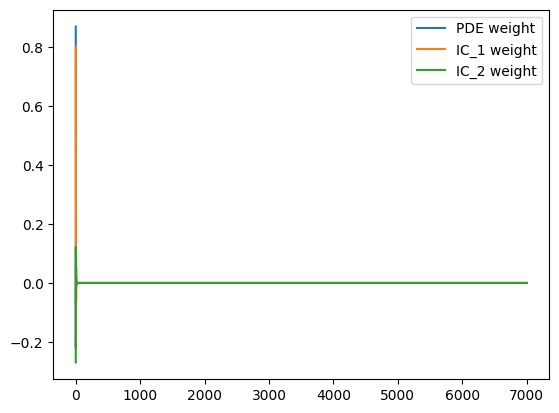

In [337]:
plt.plot(weight_history["pde_weight"], label="PDE weight")
plt.plot(weight_history["ic_1_weight"], label="IC_1 weight")
plt.plot(weight_history["ic_2_weight"], label="IC_2 weight")
plt.legend()

In [338]:
print(weight_history["pde_weight"])

[np.float64(0.8693289881881212), np.float64(-0.2176692022647644), np.float64(-0.18961620061000503), np.float64(-0.11544695000401423), np.float64(0.050953310511314735), np.float64(0.0004159088160728514), np.float64(-6.127693928699554e-05), np.float64(3.6517682629091955e-05), np.float64(3.0708749028761844e-05), np.float64(1.0881585327919742e-05), np.float64(-4.900239287464889e-06), np.float64(-2.3735897870012506e-06), np.float64(1.866398196869163e-06), np.float64(-1.7993250308262985e-06), np.float64(1.590058237205041e-06), np.float64(-5.594977939009236e-07), np.float64(-3.730922981802267e-07), np.float64(-1.4090687972596702e-07), np.float64(-6.989874269783544e-08), np.float64(-6.667500564891812e-08), np.float64(-3.71872054604993e-08), np.float64(6.676430509735085e-09), np.float64(-7.19496058879008e-10), np.float64(-6.489552355159461e-10), np.float64(-3.9204724356716807e-10), np.float64(3.397723487661637e-10), np.float64(2.3296458035063785e-10), np.float64(-5.0283050322955774e-11), np.flo

In [339]:
print(dataframe["deltapde"])

[]


In [340]:
print(dataframe["deltaic1"])

[]


In [341]:
print(dataframe["deltaic2"])

[]


In [231]:
import pandas as pd
df=pd.DataFrame(dataframe)
display(df)

ValueError: All arrays must be of the same length

In [292]:
# Create a tensor with requires_grad=True
x = torch.tensor(3.0, requires_grad=True)
# Perform operations
y = x ** 2
print(y)  # tensor(9., grad_fn=<PowBackward0>)
# Calculate gradients
y.backward()
print(x.grad)  # tensor(6.)

tensor(9., grad_fn=<PowBackward0>)
tensor(6.)


In [298]:

# Create input and target
x = torch.tensor(6.7, requires_grad=True)
y = torch.tensor(0.0)
# Initialize weights and bias
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)
# Forward pass
z = w * x + b
y_pred = torch.sigmoid(z)
# Calculate loss
loss = y_pred * (1 - y) + (1 - y_pred) * y
# Backward pass
loss.backward()
# Get gradients
print(f"dL/dw: {w.grad}")
print(f"dL/db: {b.grad}")

dL/dw: 0.008227287791669369
dL/db: 0.0012279534712433815
